In [1]:
import pyLIMA, os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyLIMA import event, telescopes
from pyLIMA.simulations import simulator
from pyLIMA.fits import TRF_fit
from pyLIMA.models import FSPL_model,USBL_model,PSPL_model
from ipywidgets import interactive, HBox, VBox, Layout
from ipywidgets import (FloatSlider, FloatLogSlider, interactive_output, HBox, VBox, GridBox, Layout, Label)
from IPython.display import display
current_path = os.getcwd()
parent_directory = os.path.abspath(os.path.join(current_path, os.pardir))
print("Parent Directory:", parent_directory)
sys.path.append(parent_directory)
import pyLIMA_plots
from astropy import units as u
from astropy import constants as C
from pyLIMA.xallarap.xallarap import xallarap_shifts, compute_xallarap_curvature
import scipy.optimize as so
import numpy as np
import pandas as pd
import astropy.units as u



Parent Directory: /home/anibal/binary_source


In [53]:
def orbital_period_kepler(a_au, M_tot_Msun):
    """
    Compute the orbital period of a binary system using Kepler's third law
    in astronomical units.

    Parameters
    ----------
    a_au : float or array-like
        Semimajor axis in astronomical units (AU).
    M_tot_Msun : float or array-like
        Total mass of the system in solar masses (M_sun).

    Returns
    -------
    P_yr : float or ndarray
        Orbital period in years.
    """
    a_au = np.asarray(a_au, dtype=float)
    M_tot_Msun = np.asarray(M_tot_Msun, dtype=float)
    print("Period ", np.sqrt(a_au**3 / M_tot_Msun), "years")
    print("converting to ", np.sqrt(a_au**3 / M_tot_Msun)*365.25, "days (to use in pyLIMA)")
    return np.sqrt(a_au**3 / M_tot_Msun)*365.25*(1/u.day)

In [ ]:

def a_from_P_kepler(P_days, Mtot_Msun):
    P_yr = np.asarray(P_days, float) / 365.25
    return (Mtot_Msun * P_yr**2)**(1/3)  # AU

# dentro del loop en P:
Mtot = M1_Msun + M2_Msun  # o Mtot fijo que elijas
a_AU = a_from_P_kepler(P, Mtot)
xiE  = a_AU / rEhat_AU
omega = 2*np.pi / P


In [3]:


def build_case(case_name, DS, DL, rEhat, v_perp, a, M1, M2,
               t0=50, u0=0.1, xi_phase=0, xi_inclination=np.pi/2, flux_ratio=0.2):
    """
    Construye un diccionario con los parámetros de un caso de xallarap.
    """
    q_xi = (M2 / M1).decompose().value
    P = orbital_period_kepler(a, M1 + M2)

    # tE = (rEhat * DL / DS) / v_perp
    tE = (rEhat) / v_perp
    return {
        "case": case_name,
        "DS_kpc": DS.to(u.kpc).value,
        "DL_kpc": DL.to(u.kpc).value,
        "rEhat_AU": rEhat.to(u.AU).value,
        "v_perp_kms": v_perp.to(u.km/u.s).value,
        "a_AU": a.to(u.AU).value,
        "M1_Msun": M1.to(u.M_sun).value,
        "M2_Msun": M2.to(u.M_sun).value,
        "xi_mass_ratio": q_xi,
        "tE": tE.to(u.day).value,
        "t0": t0,
        "u0": u0,
        "xiE": (a / rEhat).decompose().value,
        "omega_xi_1_per_day": (2*np.pi / P).value,
        "xi_phase": xi_phase,
        "xi_inclination": xi_inclination,
        "flux_ratio": flux_ratio,
        "P": P.value,
    }

DS = 8 * u.kpc
DL = 4 * u.kpc
v_perp = 50 * u.km / u.s
a = 2 * u.AU

rows = []

# =========================
# rEhat = 5 AU
# =========================

rEhat = 5 * u.AU

# Case 1: face-on, P > tE
rows.append(build_case(
    "case1", DS, DL, rEhat, v_perp, a,
    M1=2*u.M_sun, M2=1.4*u.M_sun
))

# Case 2: face-on, P < tE
rows.append(build_case(
    "case2", DS, DL, rEhat, v_perp, a,
    M1=1.4*u.M_sun, M2=100*u.M_sun
))

# Case 3a: edge-on, low mass ratio
rows.append(build_case(
    "case3a", DS, DL, rEhat, v_perp, a,
    M1=2*u.M_sun, M2=1.4*u.M_sun,
    xi_inclination=np.pi/2
))

# Case 3b: edge-on, high mass ratio
rows.append(build_case(
    "case3b", DS, DL, rEhat, v_perp, a,
    M1=1.4*u.M_sun, M2=100*u.M_sun,
    xi_inclination=np.pi/2
))

# =========================
# rEhat = 2 AU  (Case 4)
# =========================
rEhat = 2 * u.AU

rows.append(build_case(
    "case4-1", DS, DL, rEhat, v_perp, a,
    M1=2*u.M_sun, M2=1.4*u.M_sun,
    xi_inclination=0
))

rows.append(build_case(
    "case4-2", DS, DL, rEhat, v_perp, a,
    M1=1.4*u.M_sun, M2=100*u.M_sun,
    xi_inclination=0
))

rows.append(build_case(
    "case4-3a", DS, DL, rEhat, v_perp, a,
    M1=2*u.M_sun, M2=1.4*u.M_sun,
    xi_inclination=np.pi/2
))

rows.append(build_case(
    "case4-3b", DS, DL, rEhat, v_perp, a,
    M1=1.4*u.M_sun, M2=100*u.M_sun,
    xi_inclination=np.pi/2
))

df_cases = pd.DataFrame(rows).set_index("case")
df_cases


Period  1.5339299776947408 years
converting to  560.2679243530041 days (to use in pyLIMA)
Period  0.2808833628231621 years
converting to  102.59264827115996 days (to use in pyLIMA)
Period  1.5339299776947408 years
converting to  560.2679243530041 days (to use in pyLIMA)
Period  0.2808833628231621 years
converting to  102.59264827115996 days (to use in pyLIMA)
Period  1.5339299776947408 years
converting to  560.2679243530041 days (to use in pyLIMA)
Period  0.2808833628231621 years
converting to  102.59264827115996 days (to use in pyLIMA)
Period  1.5339299776947408 years
converting to  560.2679243530041 days (to use in pyLIMA)
Period  0.2808833628231621 years
converting to  102.59264827115996 days (to use in pyLIMA)


,DS_kpc,DL_kpc,rEhat_AU,v_perp_kms,a_AU,M1_Msun,M2_Msun,xi_mass_ratio,tE,t0,u0,xiE,omega_xi_1_per_day,xi_phase,xi_inclination,flux_ratio,P
case,,,,,,,,,,,,,,,,,
case1,8.0,4.0,5.0,50.0,2.0,2.0,1.4,0.700000,173.145684,50,0.1,0.4,0.011215,0,1.570796,0.2,560.267924
case2,8.0,4.0,5.0,50.0,2.0,1.4,100.0,71.428571,173.145684,50,0.1,0.4,0.061244,0,1.570796,0.2,102.592648
case3a,8.0,4.0,5.0,50.0,2.0,2.0,1.4,0.700000,173.145684,50,0.1,0.4,0.011215,0,1.570796,0.2,560.267924
case3b,8.0,4.0,5.0,50.0,2.0,1.4,100.0,71.428571,173.145684,50,0.1,0.4,0.061244,0,1.570796,0.2,102.592648
case4-1,8.0,4.0,2.0,50.0,2.0,2.0,1.4,0.700000,69.258273,50,0.1,1.0,0.011215,0,0.000000,0.2,560.267924
case4-2,8.0,4.0,2.0,50.0,2.0,1.4,100.0,71.428571,69.258273,50,0.1,1.0,0.061244,0,0.000000,0.2,102.592648
case4-3a,8.0,4.0,2.0,50.0,2.0,2.0,1.4,0.700000,69.258273,50,0.1,1.0,0.011215,0,1.570796,0.2,560.267924
case4-3b,8.0,4.0,2.0,50.0,2.0,1.4,100.0,71.428571,69.258273,50,0.1,1.0,0.061244,0,1.570796,0.2,102.592648


# Create event, define telescope and choose a model

PyLIMA need that we specify the compontents of $\xi_{E}=(\xi_{E \parallel},\xi_{E \perp}) = $.

Where $\xi_{E \parallel}=\xi_E \cos(\theta)$ and $\xi_{E \perp}=\xi_E \sin(\theta)$.


In [113]:



def mag(zp, Flux):
    '''
    Transform the flux to magnitude
    inputs
    zp: zero point
    Flux: vector that contains the lightcurve flux
    '''
    return zp - 2.5 * np.log10(abs(Flux))

def chi2_theoretical(fit_params, your_model, use_magnification=False):
    """
    Theoretical objective: unweighted L2 distance between data and model.

    Parameters
    ----------
    fit_params : array-like
        Parameter vector in the order defined by your_model.model_dictionnary.
    your_model : pyLIMA model instance
    use_magnification : bool
        If True, compares A(t) vs A_data stored in telescope.lightcurve['flux'].
        If False, compares F(t) vs flux data (pyLIMA photometry model).
    """
    list_params =  np.concatenate([fit_params, [1.0, 1.0]])
    
    py_params = your_model.compute_pyLIMA_parameters(list_params)

    sse = 0.0
    for telescope in your_model.event.telescopes:
        if telescope.lightcurve is None:
            continue

        # Data (what you put in telescope.lightcurve['flux'])
        data = telescope.lightcurve['flux'].value

        if use_magnification:
            # Compare magnifications directly:
            # model.model_magnification returns A(t)
            model_pred = your_model.model_magnification(telescope, py_params)
        else:
            # Compare photometric flux model directly: F(t) = f_s A(t) + f_b
            model_pred = your_model.compute_the_microlensing_model(
                telescope, py_params
            )['photometry']

        resid = data - model_pred
        sse += np.sum(resid**2)

    return sse



simulated_event = event.Event()
simulated_event.name = 'Simulated'
simulated_event.ra = 170
simulated_event.dec = -70

t = np.linspace(-500, 500, 5000)
lightcurve_sim = np.c_[t, np.full_like(t, 19.0), np.full_like(t, 0.000000001)]

tel = telescopes.Telescope(
    name='Simulation',
    camera_filter='G',
    lightcurve=lightcurve_sim.astype(float),
    lightcurve_names=['time','mag','err_mag'],
    lightcurve_units=['JD','mag','mag'],
    location='Earth'
)
simulated_event.telescopes.append(tel)

model_xiE = PSPL_model.PSPLmodel(simulated_event, parallax=['None', 0], double_source=['Circular', df_row['t0']]) # <--- Here I set t0,xi = t0
model_xiE.define_model_parameters()

case_name, df_row =  "case2", df_cases.loc["case2"]
params_list = [0]*12

rE = 10*u.AU
a_au=1*u.AU
M1=2*u.M_sun
M2=1*u.M_sun
M_tot_Msun =M1+M2
xiE = (a/rE).decompose()#df_row['xiE']
t_0 = 50#df_row['t0']
t_E = 173#df_row['tE']
P = orbital_period_kepler(a_au, M_tot_Msun).value#df_row['P']
print(P)
u_0 = 0.1#df_row['u0']
phi_0 = 0#df_row['xi_phase']
binary_flux_ratio = 0#df_row['flux_ratio']
q = M1/M2#df_row['xi_mass_ratio']
fb = 1
fs=1
theta =0 
lambda_xi = df_row['xi_inclination']
omega = 2*np.pi/P
# for case_name, df_row in df_cases.iterrows():

params_list[0] = t_0#- df_row['xiE']*np.cos(df_row['xi_phase'])*df_row['tE'] 
params_list[1] = u_0# +df_row['xiE']*np.sin(df_row['xi_phase'])
params_list[2] = t_E 
params_list[3] = xiE*np.cos(theta) # <---- THE SOURCE BINARY SISTEM MOVES PARALLEL TO THE SEMI MAJOR AXIS
params_list[4] = xiE*np.sin(theta) # <---- THE SOURCE BINARY SISTEM MOVES PARALLEL TO THE SEMI MAJOR AXIS
params_list[5] = omega
params_list[6] = phi_0   #< ---- Orbital phase at t0
params_list[7] = lambda_xi #pi/2
params_list[8] = q
params_list[9] = binary_flux_ratio
params_list[10] = fs 
params_list[11] = fb 

py_params_xiE = model_xiE.compute_pyLIMA_parameters(params_list)
# A = model_xiE.model_magnification(model_xiE.event.telescopes[0], py_params_xiE)

simulator.simulate_lightcurve(model_xiE, py_params_xiE)
# k=0
# model_flux_xiE = model_xiE.compute_the_microlensing_model(simulated_event.telescopes[k],
                                                             # py_params_xiE)['photometry']
for k in range(len(simulated_event.telescopes)):
    model_flux = model_xiE.compute_the_microlensing_model(simulated_event.telescopes[k],
                                                             py_params_xiE)['photometry']
    simulated_event.telescopes[k].lightcurve['flux'] = model_flux #con esto el flujo es el teorico sin errores
    simulated_event.telescopes[k].lightcurve['mag'] = mag(27,model_flux)



model_PSPL = PSPL_model.PSPLmodel(simulated_event, parallax=['None', 0], double_source=['None', 0])
your_guess = [t_0,u_0,t_E]

result = so.minimize(
    chi2_theoretical,
    x0=np.array(your_guess, dtype=float),
    args=(model_PSPL, False),     
    method='Nelder-Mead',
    options=dict(maxiter=20000, xatol=1e-10, fatol=1e-10)
)


flux_PSPL_fit = model_PSPL.compute_the_microlensing_model(
                model_PSPL.event.telescopes[0], model_PSPL.compute_pyLIMA_parameters(np.concatenate([result["x"], [fs, fb]]))
            )['photometry']


# plt.plot(model_xiE.event.telescopes[0].lightcurve['time'],model_xiE.event.telescopes[0].lightcurve['flux'], label="True model xallarap")

# plt.plot(t , flux_PSPL_fit,label = "fit pyLIMA PSPL")

resid = model_xiE.event.telescopes[0].lightcurve['flux'] - flux_PSPL_fit
RMS = float(np.sqrt(np.mean(resid**2)))
# plt.title("RMS: "+str(RMS) )
# plt.xlabel("time [days] ")
# plt.ylabel("Flux primary source (flux companion = 0)")
# plt.legend()

# A_truth (xallarap)
A_truth = model_xiE.model_magnification(
    model_xiE.event.telescopes[0], py_params_xiE
)

# A_fit (PSPL con params ajustados)
best_full = np.concatenate([result["x"], [fs, fb]])  # ojo: en tu modelo esto quizás es fsource, ftotal
py_best = model_PSPL.compute_pyLIMA_parameters(best_full)
A_fit = model_PSPL.model_magnification(
    model_PSPL.event.telescopes[0], py_best
)

RMS_A = float(np.sqrt(np.mean((A_truth - A_fit)**2)))
print("RMS in magnification =", RMS_A)


Period  0.5773502691896257 years
converting to  210.8771858215108 days (to use in pyLIMA)
210.8771858215108
RMS in magnification = 0.42975051838927797


/tmp/ipykernel_848586/1667045746.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


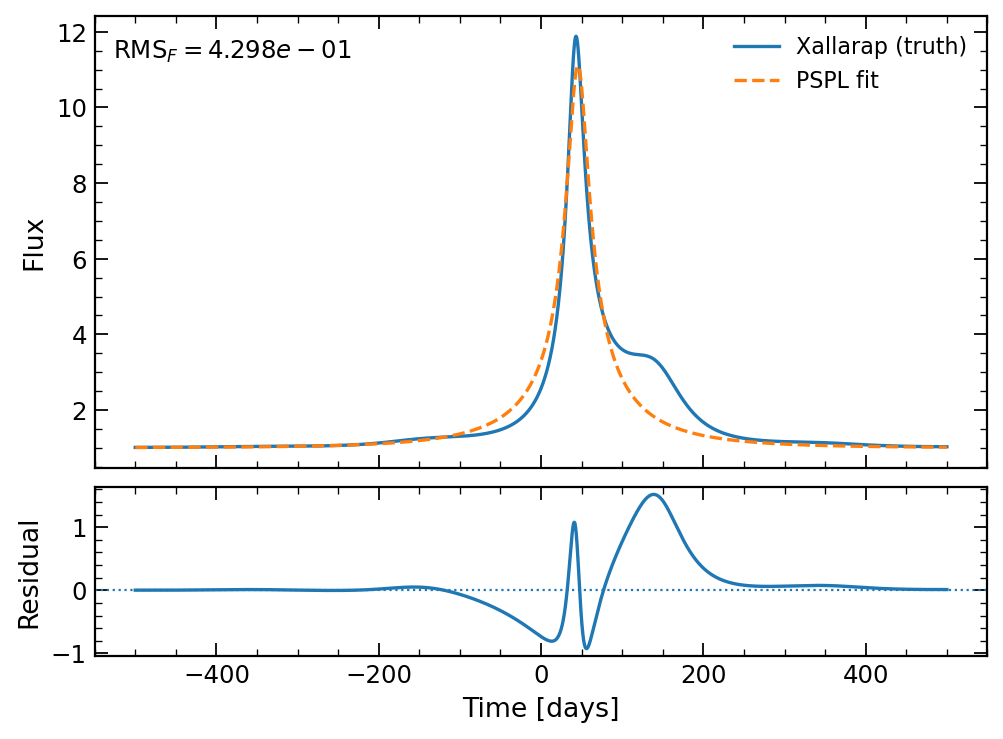

/tmp/ipykernel_848586/1667045746.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


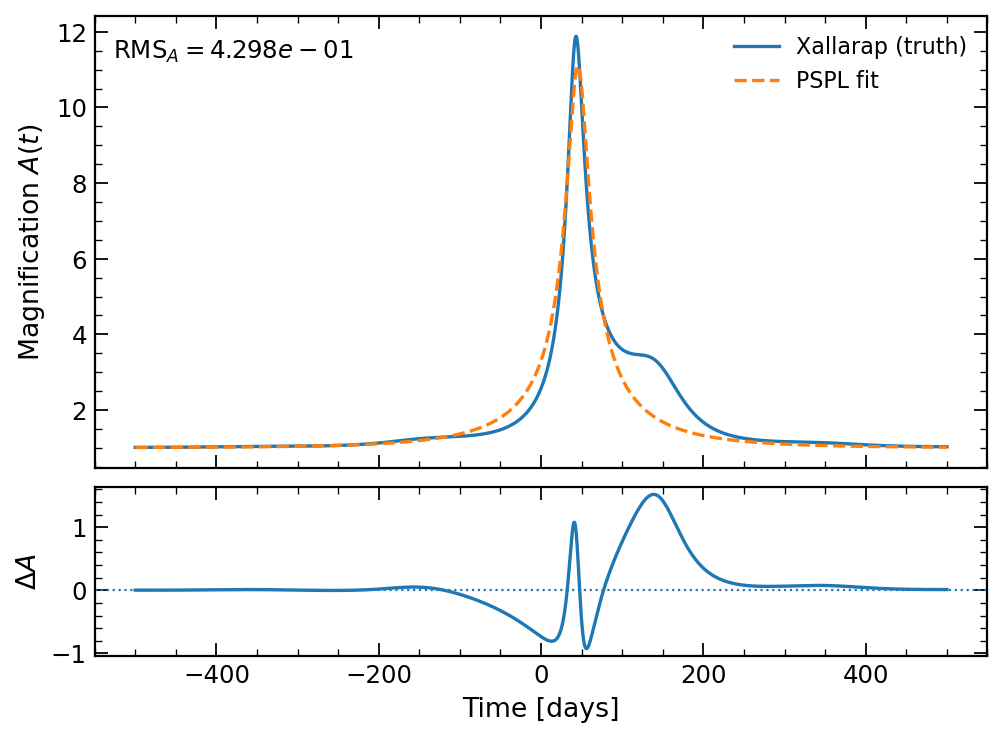

RMS in flux = 0.42975051838927797
RMS in magnification = 0.42975051838927797


In [102]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

def make_paper_figures_xallarap_vs_pspl(
    t,
    model_xiE,
    py_params_xiE,
    model_PSPL,
    result,
    fs,
    fb,
    flux_PSPL_fit,
    out_prefix="xallarap_vs_pspl",
):
    """
    Produce 2 paper-ready figures:
      (1) Flux comparison + residuals
      (2) Magnification comparison + residuals

    Saves: out_prefix + "_flux.pdf/png" and out_prefix + "_mag.pdf/png"
    """

    # ------------------------------------------------------------------
    # Helpers: "paper-like" matplotlib settings (local to these figures)
    # ------------------------------------------------------------------
    plt.rcParams.update({
        "figure.dpi": 160,
        "savefig.dpi": 300,
        "font.size": 11,
        "axes.labelsize": 12,
        "axes.titlesize": 12,
        "legend.fontsize": 10,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "axes.linewidth": 1.0,
        "xtick.direction": "in",
        "ytick.direction": "in",
        "xtick.major.size": 6,
        "ytick.major.size": 6,
        "xtick.minor.size": 3,
        "ytick.minor.size": 3,
        "xtick.top": True,
        "ytick.right": True,
    })

    # ------------------------------------------------------------------
    # 1) FLUX figure (data are theoretical fluxes in telescope.lightcurve['flux'])
    # ------------------------------------------------------------------
    time = model_xiE.event.telescopes[0].lightcurve["time"].value
    flux_truth = model_xiE.event.telescopes[0].lightcurve["flux"].value
    flux_fit = np.asarray(flux_PSPL_fit, dtype=float)

    resid_flux = flux_truth - flux_fit
    rms_flux = float(np.sqrt(np.mean(resid_flux**2)))

    fig = plt.figure(figsize=(7.2, 5.2))
    gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[3.2, 1.2], hspace=0.06)
    ax = fig.add_subplot(gs[0, 0])
    axr = fig.add_subplot(gs[1, 0], sharex=ax)

    ax.plot(time, flux_truth, label="Xallarap (truth)")
    ax.plot(t, flux_fit, linestyle="--", label="PSPL fit")

    ax.set_ylabel(r"Flux")
    ax.legend(frameon=False, loc="best")

    # RMS annotation (paper-style: small textbox, not title)
    ax.text(
        0.02, 0.95,
        rf"$\mathrm{{RMS}}_F = {rms_flux:.3e}$",
        transform=ax.transAxes,
        va="top", ha="left",
        bbox=dict(boxstyle="round,pad=0.25", facecolor="white", edgecolor="none", alpha=0.85),
    )

    axr.plot(time, resid_flux)
    axr.axhline(0.0, linestyle=":", linewidth=1.0)
    axr.set_xlabel(r"Time [days]")
    axr.set_ylabel(r"Residual")
    axr.yaxis.set_minor_locator(AutoMinorLocator())
    axr.xaxis.set_minor_locator(AutoMinorLocator())

    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    plt.setp(ax.get_xticklabels(), visible=False)

    fig.tight_layout()
    fig.savefig(f"{out_prefix}_flux.pdf", bbox_inches="tight")
    fig.savefig(f"{out_prefix}_flux.png", bbox_inches="tight")
    plt.show()

    # ------------------------------------------------------------------
    # 2) MAGNIFICATION figure (A_truth vs A_fit + residuals)
    # ------------------------------------------------------------------
    A_truth = model_xiE.model_magnification(model_xiE.event.telescopes[0], py_params_xiE)

    # IMPORTANT: pyLIMA sometimes expects [t0,u0,tE,fsource,ftotal], not [t0,u0,tE,fs,fb].
    # Here we keep your convention; if your PSPL wrapper uses ftotal, replace fb by ftotal.
    best_full = np.concatenate([np.asarray(result["x"], dtype=float), [fs, fb]])
    py_best = model_PSPL.compute_pyLIMA_parameters(best_full)
    A_fit = model_PSPL.model_magnification(model_PSPL.event.telescopes[0], py_best)

    resid_A = np.asarray(A_truth, dtype=float) - np.asarray(A_fit, dtype=float)
    rms_A = float(np.sqrt(np.mean(resid_A**2)))

    fig = plt.figure(figsize=(7.2, 5.2))
    gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[3.2, 1.2], hspace=0.06)
    ax = fig.add_subplot(gs[0, 0])
    axr = fig.add_subplot(gs[1, 0], sharex=ax)

    ax.plot(time, A_truth, label="Xallarap (truth)")
    ax.plot(time, A_fit, linestyle="--", label="PSPL fit")

    ax.set_ylabel(r"Magnification $A(t)$")
    ax.legend(frameon=False, loc="best")

    ax.text(
        0.02, 0.95,
        rf"$\mathrm{{RMS}}_A = {rms_A:.3e}$",
        transform=ax.transAxes,
        va="top", ha="left",
        bbox=dict(boxstyle="round,pad=0.25", facecolor="white", edgecolor="none", alpha=0.85),
    )

    axr.plot(time, resid_A)
    axr.axhline(0.0, linestyle=":", linewidth=1.0)
    axr.set_xlabel(r"Time [days]")
    axr.set_ylabel(r"$\Delta A$")
    axr.yaxis.set_minor_locator(AutoMinorLocator())
    axr.xaxis.set_minor_locator(AutoMinorLocator())

    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    plt.setp(ax.get_xticklabels(), visible=False)

    fig.tight_layout()
    fig.savefig(f"{out_prefix}_mag.pdf", bbox_inches="tight")
    fig.savefig(f"{out_prefix}_mag.png", bbox_inches="tight")
    plt.show()

    print("RMS in flux =", rms_flux)
    print("RMS in magnification =", rms_A)


# ------------------------------------------------------------
# USO (tal cual tu caso)
# ------------------------------------------------------------
make_paper_figures_xallarap_vs_pspl(
    t=t,
    model_xiE=model_xiE,
    py_params_xiE=py_params_xiE,
    model_PSPL=model_PSPL,
    result=result,
    fs=fs,
    fb=fb,
    flux_PSPL_fit=flux_PSPL_fit,
    out_prefix="xallarap_vs_pspl_example",
)


/tmp/ipykernel_848586/3896170531.py:60: UserWarning: AutoMinorLocator does not work on logarithmic scales
  fig.tight_layout()
/tmp/ipykernel_848586/3896170531.py:63: UserWarning: AutoMinorLocator does not work on logarithmic scales
  fig.savefig("rms_vs_period.pdf", bbox_inches="tight")
/tmp/ipykernel_848586/3896170531.py:64: UserWarning: AutoMinorLocator does not work on logarithmic scales
  fig.savefig("rms_vs_period.png", bbox_inches="tight")
/home/anibal/anaconda3/envs/roman_rubin/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: AutoMinorLocator does not work on logarithmic scales
  fig.canvas.print_figure(bytes_io, **kw)


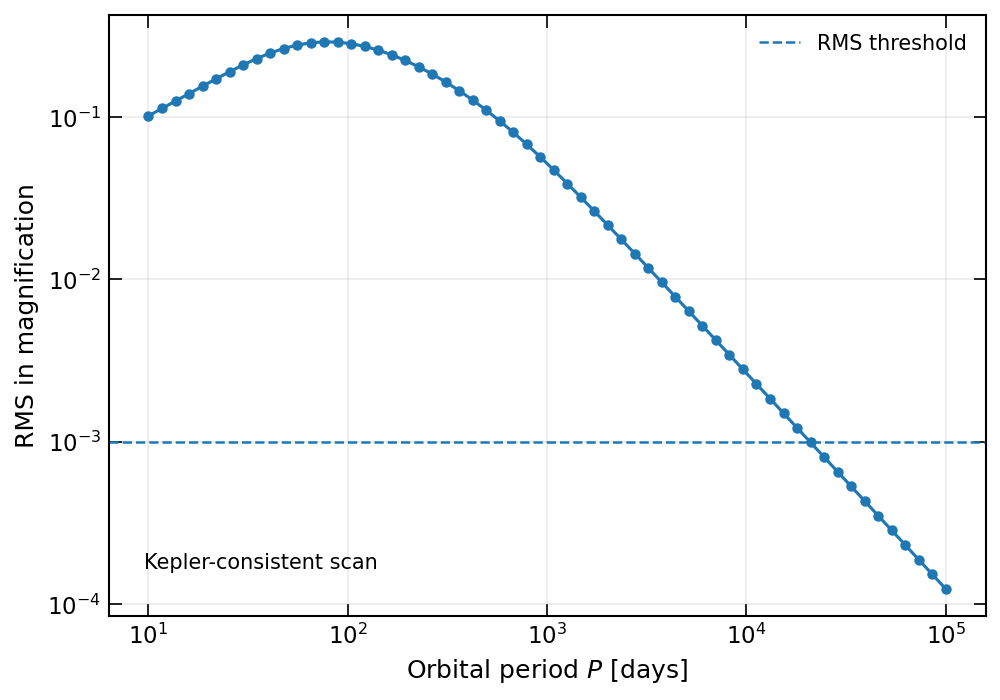

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

# Load data
data = np.load("scan_kepler.npz")
P = data["P_grid"]
RMS = data["RMS"]

# ------------------------------------------------------------
# Paper-style matplotlib configuration
# ------------------------------------------------------------
plt.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "font.size": 11,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 10,
    "axes.linewidth": 1.0,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,
})

# ------------------------------------------------------------
# Create figure
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6.8, 4.8))

ax.loglog(P, RMS, marker="o", linestyle="-", markersize=4)

# Threshold line
threshold = 1e-3
ax.axhline(threshold, linestyle="--", linewidth=1.2, label=r"RMS threshold")

# Axis labels (no title in paper figures)
ax.set_xlabel(r"Orbital period $P$ [days]")
ax.set_ylabel(r"RMS in magnification")

# Minor ticks
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

# Optional annotation
ax.text(
    0.04, 0.08,
    r"Kepler-consistent scan",
    transform=ax.transAxes,
    fontsize=10,
)

# Grid subtle
ax.grid(True, which="both", alpha=0.25)

ax.legend(frameon=False, loc="best")

fig.tight_layout()

# Save as publication-quality outputs
fig.savefig("rms_vs_period.pdf", bbox_inches="tight")
fig.savefig("rms_vs_period.png", bbox_inches="tight")

plt.show()



/tmp/ipykernel_848586/1591784143.py:30: UserWarning: AutoMinorLocator does not work on logarithmic scales
  fig.tight_layout()
/tmp/ipykernel_848586/1591784143.py:33: UserWarning: AutoMinorLocator does not work on logarithmic scales
  fig.savefig("rms_vs_xiE.pdf", bbox_inches="tight")
/tmp/ipykernel_848586/1591784143.py:34: UserWarning: AutoMinorLocator does not work on logarithmic scales
  fig.savefig("rms_vs_xiE.png", bbox_inches="tight")
/home/anibal/anaconda3/envs/roman_rubin/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: AutoMinorLocator does not work on logarithmic scales
  fig.canvas.print_figure(bytes_io, **kw)


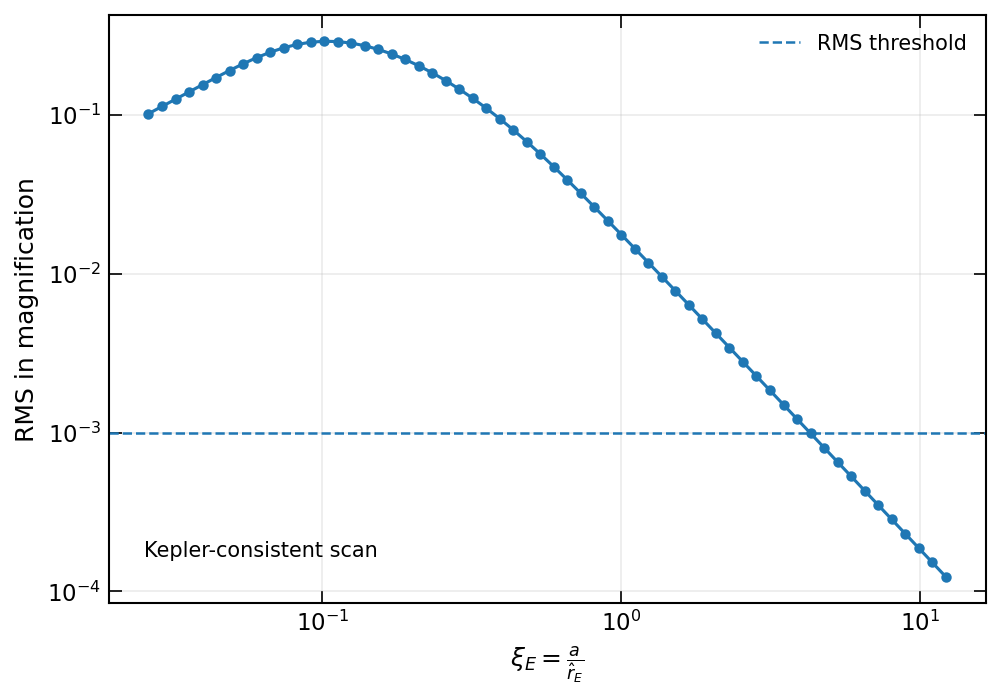

In [104]:


fig, ax = plt.subplots(figsize=(6.8, 4.8))

ax.loglog(data["xiE_of_P"], RMS, marker="o", linestyle="-", markersize=4)

# Threshold line
threshold = 1e-3
ax.axhline(threshold, linestyle="--", linewidth=1.2, label=r"RMS threshold")

# Axis labels (no title in paper figures)
ax.set_xlabel(r"$\xi_E =\frac{a}{\hat{r}_E}$")
ax.set_ylabel(r"RMS in magnification")

# Minor ticks
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

# Optional annotation
ax.text(
    0.04, 0.08,
    r"Kepler-consistent scan",
    transform=ax.transAxes,
    fontsize=10,
)

# Grid subtle
ax.grid(True, which="both", alpha=0.25)

ax.legend(frameon=False, loc="best")

fig.tight_layout()

# Save as publication-quality outputs
fig.savefig("rms_vs_xiE.pdf", bbox_inches="tight")
fig.savefig("rms_vs_xiE.png", bbox_inches="tight")

plt.show()


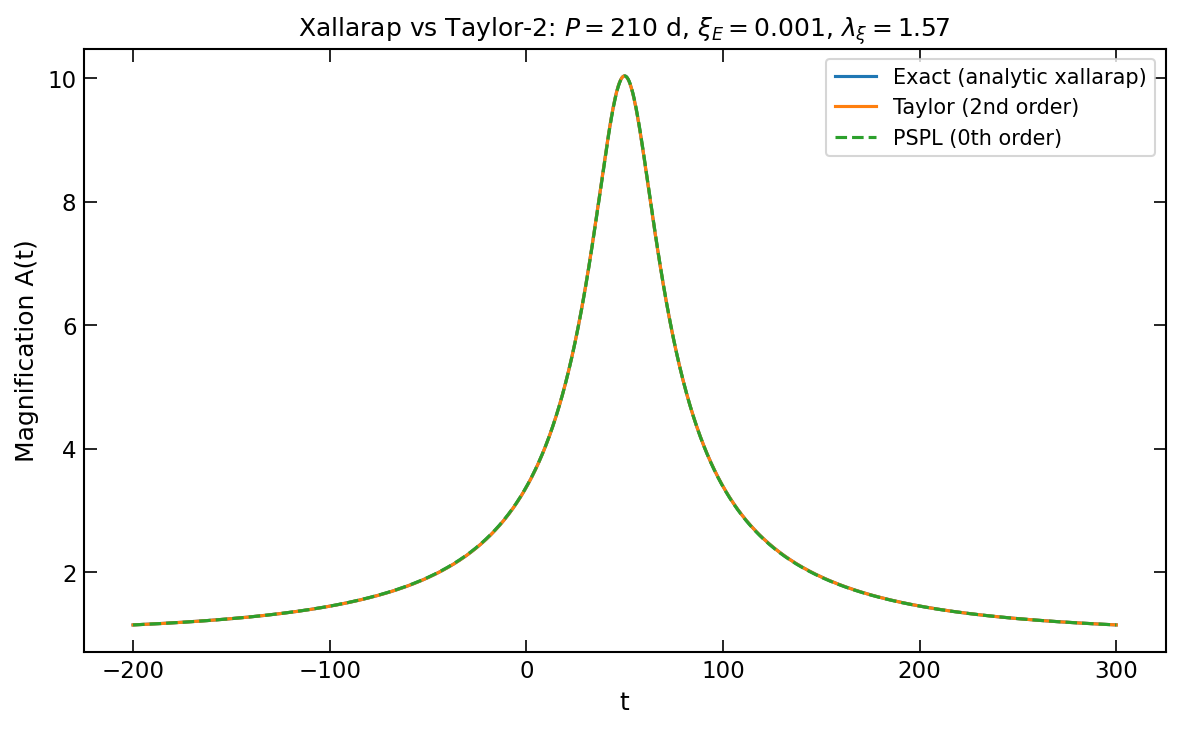

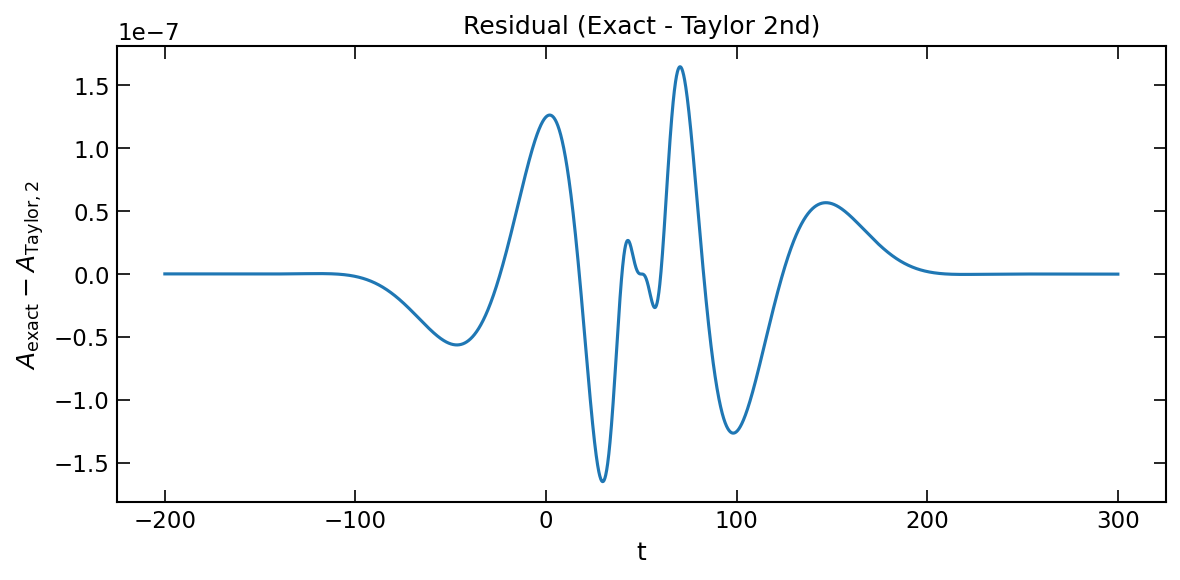

In [110]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Paczynski magnification + derivatives
# ============================================================

def A_paczynski(u):
    u = np.asarray(u, dtype=float)
    return (u*u + 2.0) / (u * np.sqrt(u*u + 4.0))

def dA_du(u):
    u = np.asarray(u, dtype=float)
    return -8.0 / (u*u * (u*u + 4.0)**1.5)

def d2A_du2(u):
    u = np.asarray(u, dtype=float)
    return 8.0*(5.0*u*u + 8.0) / (u**3 * (u*u + 4.0)**2.5)

# ============================================================
# Unperturbed trajectory
# ============================================================

def tau_beta(time, t0, tE, u0):
    tau = (time - t0) / tE
    beta = np.full_like(tau, u0, dtype=float)
    return tau, beta

# ============================================================
# Analytic circular-xallarap deltas (from your appendix)
#   Sx = cosΩ - cosφ
#   Sy = sinλ (sinΩ - sinφ)
#   Ω(t) = ω(t - t0xi) + φ, ω=2π/P
#   ξ_vec = ξE (cosθ, sinθ)
#   δτ = ξ · S
#   δβ = ξ × S = ξx Sy - ξy Sx
# ============================================================

def S_vector(time, P_days, t0xi, phi_xi, lambda_xi):
    omega = 2.0*np.pi / P_days
    Omega = omega*(time - t0xi) + phi_xi
    Sx = np.cos(Omega) - np.cos(phi_xi)
    Sy = np.sin(lambda_xi) * (np.sin(Omega) - np.sin(phi_xi))
    return Sx, Sy

def deltas_xallarap(time, xiE, theta, P_days, t0xi, phi_xi, lambda_xi):
    Sx, Sy = S_vector(time, P_days, t0xi, phi_xi, lambda_xi)
    xi_par  = xiE*np.cos(theta)
    xi_perp = xiE*np.sin(theta)

    d_tau  = xi_par*Sx + xi_perp*Sy
    d_beta = xi_par*Sy - xi_perp*Sx
    return d_tau, d_beta

# ============================================================
# Exact and Taylor-2nd-order magnifications
# ============================================================

def A_full(time, t0, tE, u0, d_tau, d_beta):
    tau, beta = tau_beta(time, t0, tE, u0)
    u = np.sqrt((tau + d_tau)**2 + (beta + d_beta)**2)
    return A_paczynski(u)

def A_taylor_2nd(time, t0, tE, u0, d_tau, d_beta):
    tau, beta = tau_beta(time, t0, tE, u0)
    u_pspl = np.sqrt(tau*tau + beta*beta)

    # Δu first order
    term1 = (tau*d_tau + beta*d_beta) / u_pspl

    # Δu second-order correction in u(t)
    term2 = (1.0/(2.0*u_pspl)) * (
        d_tau**2 + d_beta**2
        - (tau*d_tau + beta*d_beta)**2 / (u_pspl**2)
    )

    A0 = A_paczynski(u_pspl)

    # Up to O(δ^2):
    # A ≈ A0 + A'(u0)*term1 + A'(u0)*term2 + 1/2 A''(u0)*term1^2
    A1 = dA_du(u_pspl) * term1
    A2 = dA_du(u_pspl) * term2 + 0.5 * d2A_du2(u_pspl) * (term1**2)

    return A0 + A1 + A2

# ============================================================
# Plot helper
# ============================================================

def plot_lightcurve_taylor2(
    time,
    t0=50.0, u0=0.1, tE=173.0,
    xiE=1e-3, P_days=200.0,
    theta=0.0,
    t0xi=50.0, phi_xi=0.0, lambda_xi=np.pi/2,
    plot_residual=True,
):
    d_tau, d_beta = deltas_xallarap(time, xiE, theta, P_days, t0xi, phi_xi, lambda_xi)

    A_exact = A_full(time, t0, tE, u0, d_tau, d_beta)
    A_t2    = A_taylor_2nd(time, t0, tE, u0, d_tau, d_beta)
    A_pspl  = A_paczynski(np.sqrt(((time - t0)/tE)**2 + u0**2))

    plt.figure(figsize=(8,5))
    plt.plot(time, A_exact, label="Exact (analytic xallarap)")
    plt.plot(time, A_t2,    label="Taylor (2nd order)")
    plt.plot(time, A_pspl,  ls="--", label="PSPL (0th order)")
    plt.xlabel("t")
    plt.ylabel("Magnification A(t)")
    plt.title(rf"Xallarap vs Taylor-2: $P={P_days:g}$ d, $\xi_E={xiE:g}$, $\lambda_\xi={lambda_xi:.2f}$")
    plt.legend()
    plt.tight_layout()
    plt.show()

    if plot_residual:
        plt.figure(figsize=(8,4))
        plt.plot(time, A_exact - A_t2)
        plt.xlabel("t")
        plt.ylabel(r"$A_{\rm exact}-A_{\rm Taylor,2}$")
        plt.title("Residual (Exact - Taylor 2nd)")
        plt.tight_layout()
        plt.show()

    return {"A_exact": A_exact, "A_taylor2": A_t2, "A_pspl": A_pspl,
            "delta_tau": d_tau, "delta_beta": d_beta}

# ============================================================
# Example
# ============================================================

t = np.linspace(-200, 300, 4000)

out = plot_lightcurve_taylor2(
    time=t,
    t0=50.0, u0=0.1, tE=173.0,
    xiE=1e-3,
    P_days=210.0,
    theta=0.0,
    t0xi=50.0, phi_xi=0.0, lambda_xi=np.pi/2,
    plot_residual=True,
)

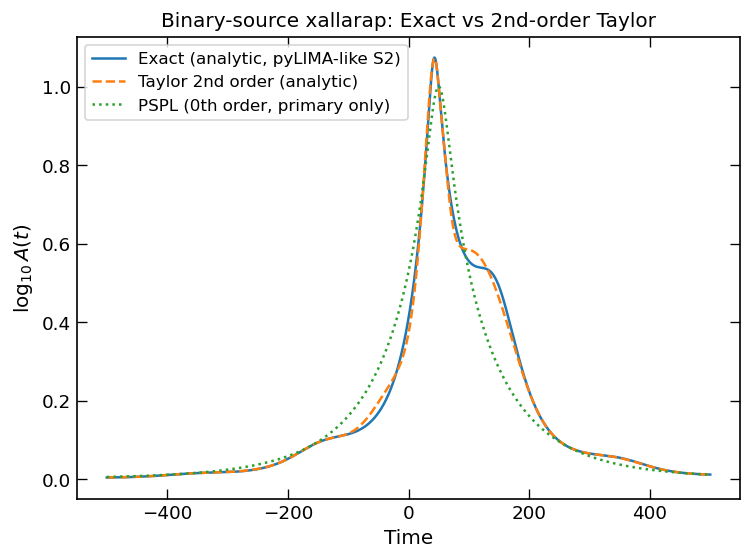

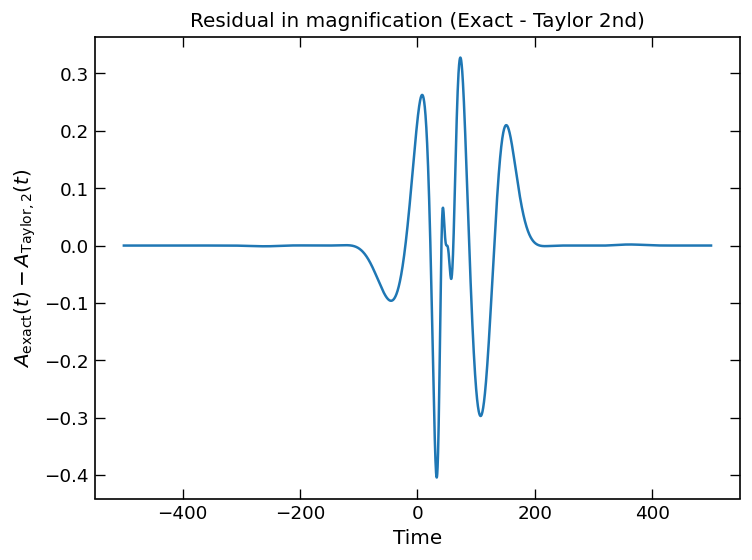

In [114]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Paczynski + derivatives
# ============================================================

def A_u(u):
    u = np.asarray(u, dtype=float)
    return (u**2 + 2.0) / (u * np.sqrt(u**2 + 4.0))

def dA_du(u):
    u = np.asarray(u, dtype=float)
    return -8.0 / (u**2 * (u**2 + 4.0)**1.5)

def d2A_du2(u):
    u = np.asarray(u, dtype=float)
    return 8.0 * (5.0*u**2 + 8.0) / (u**3 * (u**2 + 4.0)**2.5)

# ============================================================
# Your "Somayeh-Carmen" (pyLIMA-like) exact binary-source magnification
# (This matches your A_Binary_SC with pyLIMA's choice for source 2)
# ============================================================

def A_binary_exact_pylima_choice(t, t0, u0, tE, xiE, omega, phi0, lambda_xi, q, qflux):
    """
    Exact analytic version of your A_Binary_SC (with pyLIMA's S2 choice).

    q     = mass ratio M2/M1 (your df_row['xi_mass_ratio'])
    qflux = binary_flux_ratio = Fs2/Fs1

    Returns:
      A_binary(t) = A1(u1) + qflux * A2(u2)
    """
    t = np.asarray(t, dtype=float)

    Omega = omega*(t - t0) + phi0
    tau = (t - t0)/tE

    # barycentric weights (your a1)
    a1 = q/(1.0 + q)

    # --- primary displacement built from (cosΩ-cosφ, sinλ(sinΩ-sinφ))
    d_tau  = xiE*(np.cos(Omega) - np.cos(phi0))
    d_beta = xiE*np.sin(lambda_xi)*(np.sin(Omega) - np.sin(phi0))

    u1 = np.sqrt((u0 + a1*d_beta)**2 + (tau + a1*d_tau)**2)

    # --- pyLIMA "election" for source 2 (your dx2, dy2)
    dx2 = -(1.0/(1.0+q))*np.cos(Omega) - (q/(1.0+q))*np.cos(phi0)
    dy2 = -(1.0/(1.0+q))*np.sin(Omega) - (q/(1.0+q))*np.sin(phi0)

    u2 = np.sqrt((u0 + xiE*dy2)**2 + (tau + xiE*dx2)**2)

    A1 = A_u(u1)
    A2 = A_u(u2)
    return A1 + qflux*A2

# ============================================================
# Taylor expansion (2nd order) around *PSPL* trajectory of each source
# using your generic formula:
#   u = u_pspl + (tau δτ + beta δβ)/u_pspl + ...
#   A = A(u_pspl) + A'(u_pspl) Δu + 1/2 A''(u_pspl) (Δu)^2  (truncate O(δ^2))
#
# We'll apply this separately to source 1 and source 2, then combine:
#   A_bin_T2 = A1_T2 + qflux*A2_T2
# ============================================================

def A_taylor2_for_one_source(t, t0, u0, tE, delta_tau, delta_beta):
    """
    Second-order Taylor approximation for A(t) given analytic (delta_tau, delta_beta)
    around the unperturbed PSPL trajectory tau=(t-t0)/tE, beta=u0.

    This is exactly consistent to O(δ^2):
      A ≈ A0 + A'(u0)*Δu1 + A'(u0)*Δu2 + 1/2 A''(u0)*(Δu1)^2
    where
      Δu1 = (tau δτ + beta δβ)/u_pspl
      Δu2 = 1/(2u_pspl)[ δτ^2 + δβ^2 - (tau δτ + beta δβ)^2/u_pspl^2 ]
    """
    t = np.asarray(t, dtype=float)
    tau = (t - t0)/tE
    beta = np.full_like(tau, u0, dtype=float)
    u_pspl = np.sqrt(tau*tau + beta*beta)

    dot = tau*delta_tau + beta*delta_beta
    Du1 = dot / u_pspl
    Du2 = (1.0/(2.0*u_pspl)) * (delta_tau**2 + delta_beta**2 - (dot**2)/(u_pspl**2))

    A0 = A_u(u_pspl)
    A1 = dA_du(u_pspl) * Du1
    A2 = dA_du(u_pspl) * Du2 + 0.5*d2A_du2(u_pspl) * (Du1**2)

    return A0 + A1 + A2

def A_binary_taylor2_pylima_choice(t, t0, u0, tE, xiE, omega, phi0, lambda_xi, q, qflux):
    """
    Second-order Taylor approximation of your pyLIMA-like binary-source model.
    We build δτ,δβ for each source consistently with the *exact* construction used above.

    Source 1:
      delta_tau1  = a1 * xiE*(cosΩ - cosφ)
      delta_beta1 = a1 * xiE*sinλ*(sinΩ - sinφ)

    Source 2 (pyLIMA election):
      delta_tau2  = xiE*dx2
      delta_beta2 = xiE*dy2
    """
    t = np.asarray(t, dtype=float)
    Omega = omega*(t - t0) + phi0

    a1 = q/(1.0 + q)

    # source 1 deltas
    d_tau1  = a1 * xiE*(np.cos(Omega) - np.cos(phi0))
    d_beta1 = a1 * xiE*np.sin(lambda_xi)*(np.sin(Omega) - np.sin(phi0))

    # source 2 deltas (pyLIMA election)
    dx2 = -(1.0/(1.0+q))*np.cos(Omega) - (q/(1.0+q))*np.cos(phi0)
    dy2 = -(1.0/(1.0+q))*np.sin(Omega) - (q/(1.0+q))*np.sin(phi0)
    d_tau2  = xiE*dx2
    d_beta2 = xiE*dy2

    A1_T2 = A_taylor2_for_one_source(t, t0, u0, tE, d_tau1, d_beta1)
    A2_T2 = A_taylor2_for_one_source(t, t0, u0, tE, d_tau2, d_beta2)

    return A1_T2 + qflux*A2_T2

# ============================================================
# Plot for your case2 parameters (reusing your variables)
# ============================================================

def plot_case2_taylor2_vs_exact(
    t,
    t0, u0, tE,
    xiE, P_days, phi0, lambda_xi, q, qflux,
    show_pspl0=True,
    show_residual=True,
):
    omega = 2.0*np.pi / P_days

    A_exact = A_binary_exact_pylima_choice(t, t0, u0, tE, xiE, omega, phi0, lambda_xi, q, qflux)
    A_T2    = A_binary_taylor2_pylima_choice(t, t0, u0, tE, xiE, omega, phi0, lambda_xi, q, qflux)

    # "0th order" reference: just PSPL of the primary with no xallarap and no second source
    # (You can change this if you prefer a different baseline.)
    if show_pspl0:
        tau = (t - t0)/tE
        u_pspl = np.sqrt(tau**2 + u0**2)
        A0 = A_u(u_pspl)
    else:
        A0 = None

    plt.figure(dpi=120)
    plt.plot(t, np.log10(A_exact), label="Exact (analytic, pyLIMA-like S2)")
    plt.plot(t, np.log10(A_T2), "--", label="Taylor 2nd order (analytic)")

    if A0 is not None:
        plt.plot(t, np.log10(A0), ":", label="PSPL (0th order, primary only)")

    plt.xlabel("Time")
    plt.ylabel(r"$\log_{10} A(t)$")
    plt.title("Binary-source xallarap: Exact vs 2nd-order Taylor")
    plt.legend()
    plt.tight_layout()
    plt.show()

    if show_residual:
        plt.figure(dpi=120)
        plt.plot(t, A_exact - A_T2)
        plt.xlabel("Time")
        plt.ylabel(r"$A_{\rm exact}(t) - A_{\rm Taylor,2}(t)$")
        plt.title("Residual in magnification (Exact - Taylor 2nd)")
        plt.tight_layout()
        plt.show()

    return A_exact, A_T2

# ============================================================
# USAGE: plug your already-defined case2 variables
# ============================================================
# You already have:
#   t, t_0, u_0, t_E, xiE, P, phi_0, lambda_xi, q, binary_flux_ratio
#
# So just call:
#
A_exact, A_T2 = plot_case2_taylor2_vs_exact(
    t=t,
    t0=t_0, u0=u_0, tE=t_E,
    xiE=xiE, P_days=P,
    phi0=phi_0, lambda_xi=lambda_xi,
    q=q, qflux=binary_flux_ratio,
    show_pspl0=True,
    show_residual=True,
)